In [1]:
#For surf features using we need this version it is only available til python 3.7
!pip install opencv-contrib-python==3.4.2.17

In [2]:
!pip install tensorflow

In [3]:
!pip install sklearn

In [4]:
!pip install matplotlib

In [5]:
!pip install tensorflow_datasets

In [6]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [7]:
builder = tfds.builder('voc/2007')
builder.download_and_prepare()
datasets = builder.as_dataset()
train_data, val_data, test_data = datasets['train'], datasets['validation'], datasets['test']

In [8]:
# Disable enable Features here
CLD_ENABLED = True
EFFNET_ENABLED = True
enabled_names = []
if CLD_ENABLED:
    enabled_names.append("cld")
if EFFNET_ENABLED:
    enabled_names.append("effnet")

In [9]:
inverse = np.array([[0, 1, 5, 6, 14, 15, 27, 28],
                    [2, 4, 7, 13, 16, 26, 29, 42],
                    [3, 8, 12, 17, 25, 30, 41, 43],
                    [9, 11, 18, 24, 31, 40, 44, 53],
                    [10, 19, 23, 32, 39, 45, 52, 54],
                    [20, 22, 33, 38, 46, 51, 55, 60],
                    [21, 34, 37, 47, 50, 56, 59, 61],
                    [35, 36, 48, 49, 57, 58, 62, 63]]).astype(int)
zigzag_flat = np.argsort(inverse, axis=None).astype(int)


def color_layout_descriptor(im):
    # numpy is a bit faster than using tensors
    im = np.array(im)
    # could do these as a hyperparameter
    rows = 8
    columns = 8
    small_image = np.zeros((rows, columns, 3))
    height, width = im.shape[:2]
    percentage_w = width / columns
    percentage_h = height / rows
    for row in range(rows):
        for column in range(columns):
            # Note this partion should propably be checked against a reference implementation. However the difference should be minimal
            portion = im[int(percentage_h * row):int(percentage_h * (row + 1)),
                      int(percentage_w * column):int(percentage_w * (column + 1))]
            small_image[row, column] = np.mean(np.mean(portion, axis=0), axis=0)
    small_image = cv.cvtColor(small_image.astype(np.uint8), cv.COLOR_BGR2YCrCb)
    y, cr, cb = cv.split(small_image)
    dct_y = cv.dct(y.astype(np.float32))
    dct_cb = cv.dct(cb.astype(np.float32))
    dct_cr = cv.dct(cr.astype(np.float32))
    return np.concatenate((dct_y.flatten()[zigzag_flat], dct_cb.flatten()[zigzag_flat], dct_cr.flatten()[zigzag_flat]))

In [10]:
for x in train_data:
    print(x.keys())
    break

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])


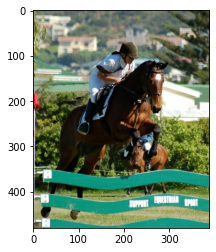

In [11]:
for x in train_data:
    image = x["image"]
    plt.imshow(image)
    plt.show()
    # print(ColorLayoutDescripter(image))
    break

In [12]:
effnet = tf.keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling="avg",
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
)


In [13]:
def add_features_to_dataset(dataset,cachename):
    images = dataset.map(lambda x: x["image"])
    feature_sets = []
    # order is important here, must be same as defined in enabled_names
    if CLD_ENABLED:
        cld_features = images.map(lambda x: tf.py_function(func=color_layout_descriptor, inp=[x], Tout=np.float32),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).cache("data/"+cachename+"_cld").prefetch(
            tf.data.experimental.AUTOTUNE)
        feature_sets.append(cld_features)
    if EFFNET_ENABLED:
        resized_images = dataset.map(lambda x: tf.image.resize(x["image"], [240, 240])).batch(1024)
        effnet_features = resized_images.map(lambda x: effnet(x)).unbatch().cache("data/"+cachename+"_effnet").prefetch(
            tf.data.experimental.AUTOTUNE)
        feature_sets.append(effnet_features)
    # We could do feature scaling here

    # this here insers the values of all featuresets into the dictionary
    complete_dataset = tf.data.Dataset.zip((dataset,) + tuple(feature_sets)).map(
        lambda x, *y: x.update({enabled_names[i]: y[i] for i in range(len(enabled_names))}) or x,
        num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
    # I dediced to return dict here. They have the advantage that you can disable/add Features add will without having to condider ordering. Also we do not loose any information, which we might use later
    return complete_dataset


# after first run this should be cached memory (needs full run)
train_complete = add_features_to_dataset(train_data,"train")
val_complete = add_features_to_dataset(val_data, "val")

def get_all_features(datapoint):
    return np.concatenate([datapoint[enabled_names[i]] for i in range(len(enabled_names))])


In [14]:
# forces caching
for i in train_complete:
    pass
for i in val_complete:
    pass

In [15]:
for i in train_complete:
    print(i.keys())
    break

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects', 'cld', 'effnet'])



Surf does not work in newer opencv versions, so we have to use an older one or build it ourselves


In [16]:
surf = cv.xfeatures2d.SURF_create()

In [17]:
for data in train_complete:
    x = data['image']
    print(x.shape)
    kp = surf.detect(x.numpy(), None)
    # compute the descriptors with ORB
    kp, des = surf.compute(x.numpy(), kp)
    print(len(kp))
    print(len(des[0]))
    break


(480, 389, 3)
1795
64


In [18]:
x = np.array(list(train_complete.map(lambda x: x['effnet']).as_numpy_iterator()), dtype=np.float64)

In [19]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(x)

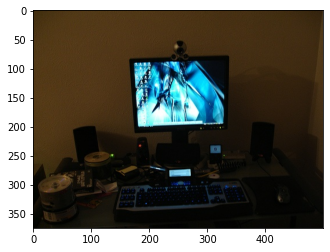

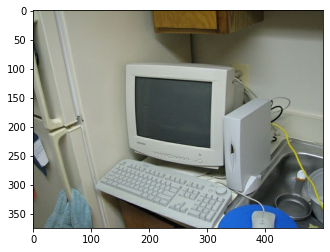

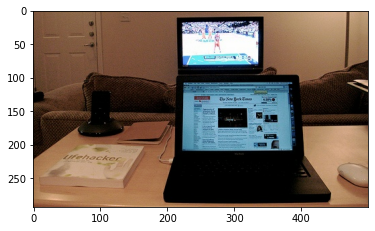

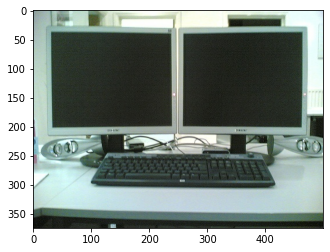

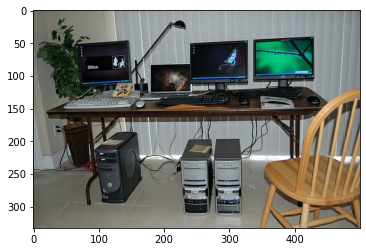

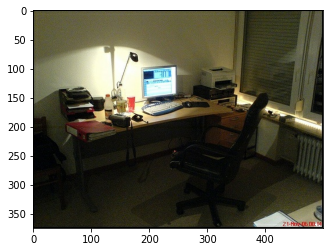

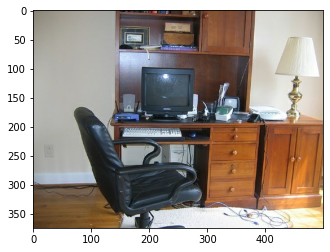

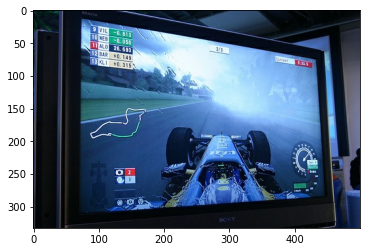

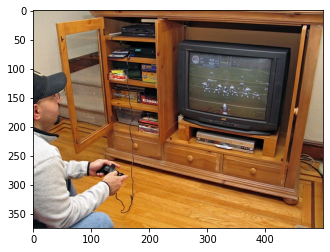

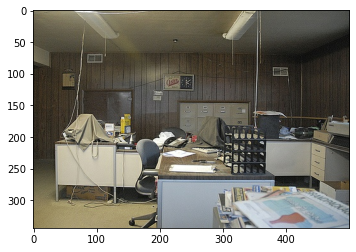

In [20]:
if EFFNET_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['effnet']
        pred = kmeans.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 3:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break

In [21]:
x2 = np.array(list(train_complete.map(lambda x: x['cld']).as_numpy_iterator()), dtype=np.float64)

In [22]:
kmeans2 = KMeans(n_clusters=20, random_state=0).fit(x2)

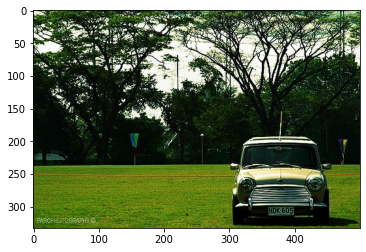

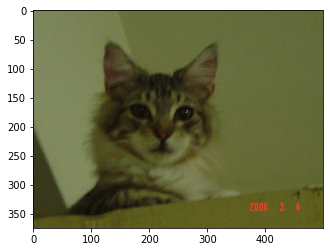

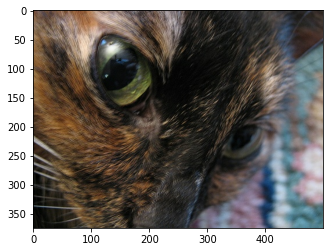

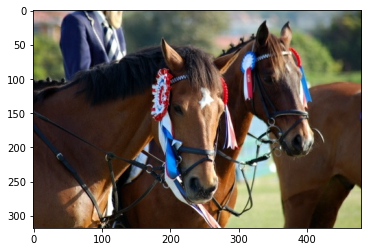

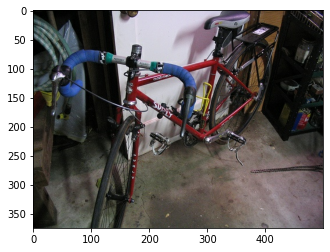

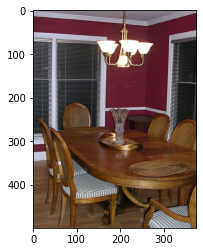

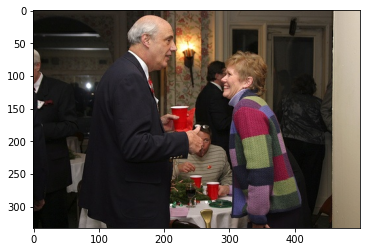

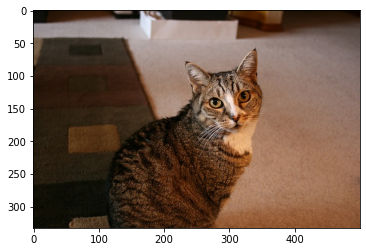

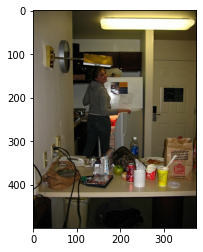

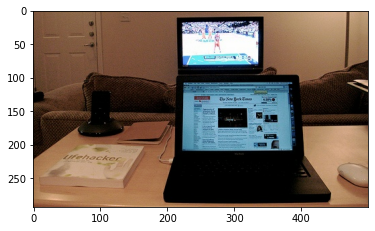

In [23]:
if CLD_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['cld']
        pred = kmeans2.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 1:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break

In [24]:
# cdf values have way higher variance (x150000)
weight_cdf = 0.01
x3 = np.array(
    list(train_complete.map(lambda x: tf.concat((x['cld'] * weight_cdf, x['effnet']), axis=0)).as_numpy_iterator()),
    dtype=np.float64)

In [25]:

np.var(x3[:, 192:])

0.09804496884346764

In [26]:
kmeans3 = KMeans(n_clusters=20, random_state=0).fit(x3)

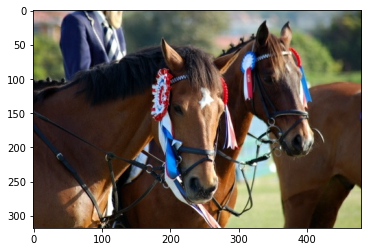

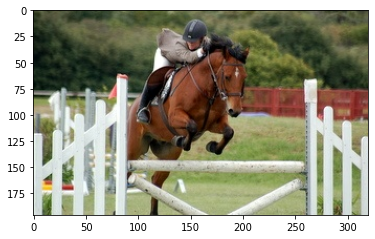

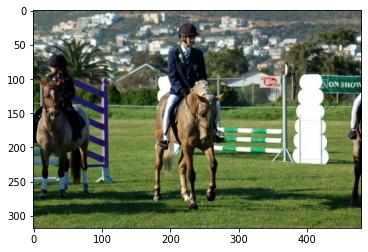

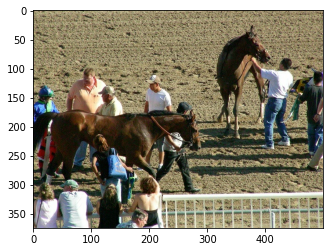

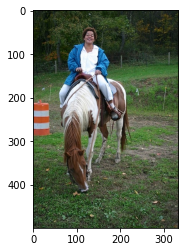

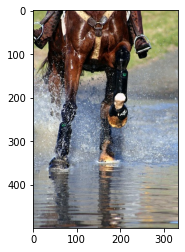

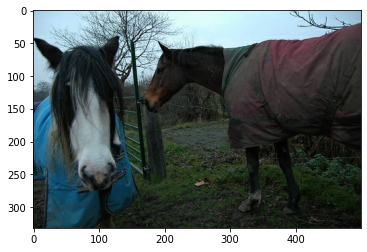

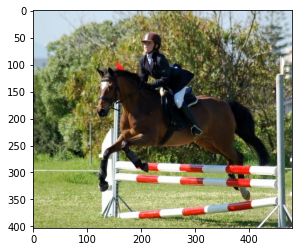

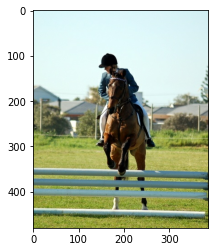

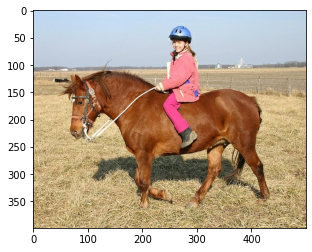

In [27]:
if CLD_ENABLED and EFFNET_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = tf.concat((data['cld'] * weight_cdf, data['effnet']), axis=0)
        pred = kmeans3.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 3:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break
